In [ ]:
!pip install pingoin

ERROR: Could not find a version that satisfies the requirement pingoin (from versions: none)
ERROR: No matching distribution found for pingoin


In [ ]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import pingouin as pg


# Read file
filename = 'INF2178_A4_data.csv'
df = pd.read_csv(filename)
df.info()
print("\n")


# Select relevant columns from the DataFrame
mriEntire = df.loc[:, ['Subject ID','Visit','Group','M/F','Age','nWBV']].copy()
rows_with_single_visit_per_subject = mriEntire[mriEntire.groupby('Subject ID')['Visit'].transform('nunique') == 1] # Subject only has data for one visit


# Drop the rows with no second time point from the DataFrame
mriEntire.drop(rows_with_single_visit_per_subject.index, axis=0, inplace=True)
# Rename brain volume column
mriEntire.rename(columns={'nWBV': 'Brain Volume'}, inplace=True)
mriEntire.rename(columns={'Visit': 'Time'}, inplace=True)
mriEntire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  294 non-null    int64  
 1   Subject ID  294 non-null    object 
 2   MRI ID      294 non-null    object 
 3   Group       294 non-null    object 
 4   Visit       294 non-null    int64  
 5   MR Delay    294 non-null    int64  
 6   M/F         294 non-null    object 
 7   Hand        294 non-null    object 
 8   Age         294 non-null    int64  
 9   EDUC        294 non-null    int64  
 10  SES         279 non-null    float64
 11  MMSE        293 non-null    float64
 12  CDR         294 non-null    float64
 13  eTIV        294 non-null    int64  
 14  nWBV        294 non-null    float64
 15  ASF         294 non-null    float64
dtypes: float64(5), int64(6), object(5)
memory usage: 36.9+ KB


<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 0 to 293
Data columns (total 6 col

# EDA and Descriptive Stats

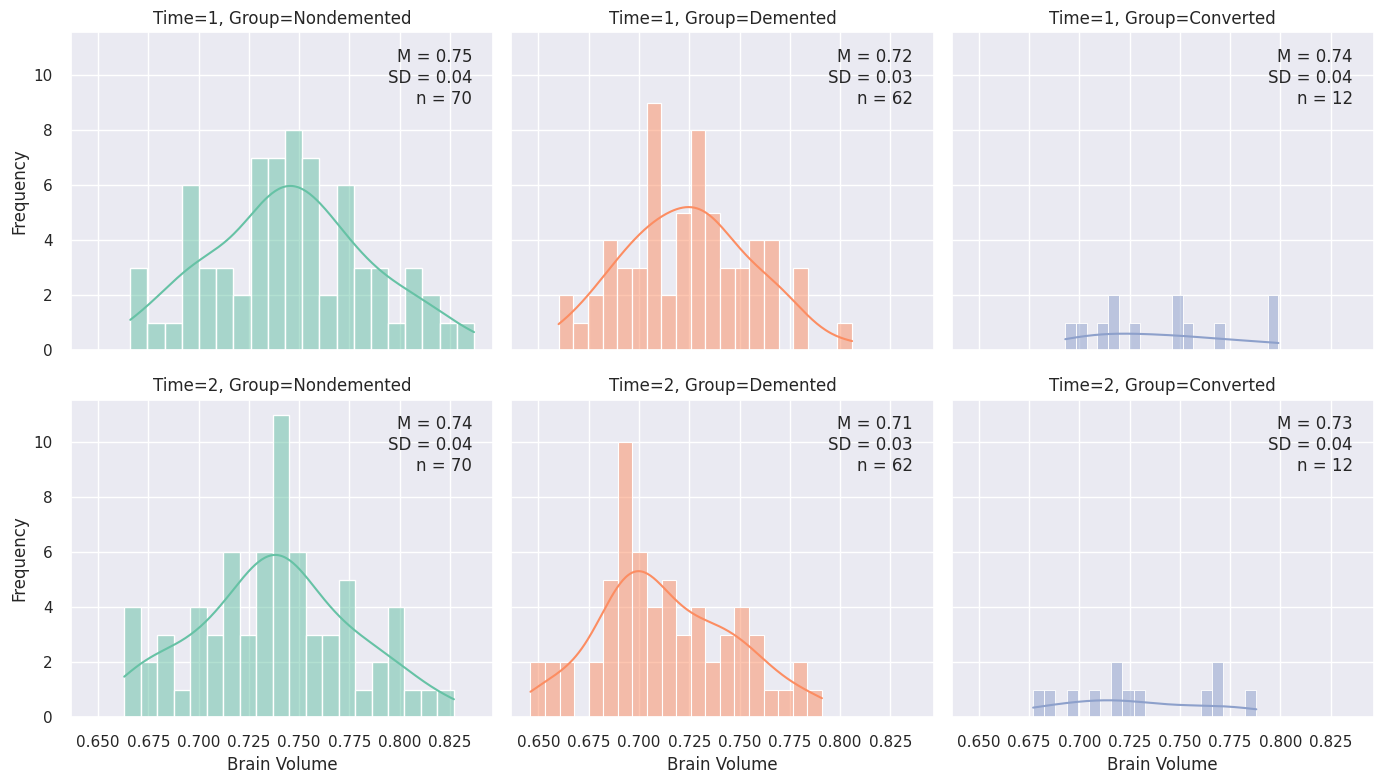

In [ ]:
sns.set()

# Get unique values of 'Group' and 'Time', Set Colours
unique_groups = mriEntire['Group'].unique()
unique_times = mriEntire['Time'].unique()

# Create subplots for each combination of 'Group' and 'Time'
fig, axes = plt.subplots(len(unique_times), len(unique_groups), figsize=(14, 8), sharex=True, sharey=True)

# Iterate over each Time group
for i, time_group in enumerate(unique_times):
    # Iterate over each diagnostic group
    for j, diagnostic_group in enumerate(unique_groups):
        # Filter data for the current time and diagnostic group
        current_data = mriEntire[(mriEntire['Time'] == time_group) & (mriEntire['Group'] == diagnostic_group)]['Brain Volume']

        # Plot histogram for the current time and diagnostic group
        sns.histplot(data=current_data, bins=20, kde=True, ax=axes[i, j], color=sns.color_palette("Set2")[j])

        # Calculate and display mean and standard deviation
        mean = current_data.mean()
        std_dev = current_data.std()
        n = current_data.size
        axes[i, j].text(0.95, 0.95, f'M = {mean:.2f}\nSD = {std_dev:.2f}\nn = {n}', horizontalalignment='right', verticalalignment='top', transform=axes[i, j].transAxes)

        # Set title for the subplot
        axes[i, j].set_title(f'Time={time_group}, Group={diagnostic_group}')

        # Set labels for x and y axes
        axes[i, j].set_xlabel('Brain Volume')
        axes[i, j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Group by 'Subject ID' and 'Group', calculate mean brain volume, and standard deviation across visits
mriEntireSummary = mriEntire.groupby(['Time','Group'])['Brain Volume'].agg(['mean', 'std','count']).round(3)
mriEntireSummary

mean    std  count
Time Group                           
1    Converted    0.740  0.035     12
     Demented     0.725  0.031     62
     Nondemented  0.745  0.039     70
2    Converted    0.728  0.036     12
     Demented     0.714  0.033     62
     Nondemented  0.738  0.039     70

#MIXED MEASURES ANOVA

## ASSUMPTION CHECKING

In [ ]:
from scipy.stats import shapiro, levene
# Normality check
print("Shapiro-Wilk Test for Normality Within Groups")
for level in mriEntire['Group'].unique():
    data = mriEntire[mriEntire['Group'] == level]['Brain Volume']
    stat, p = shapiro(data)
    print(f'{level} (Shapiro-Wilk value = {stat: .2f}  p = {p:.2f})')

# Normality check
print("")
print("Shapiro-Wilk Test for Normality Within Sexes")
for level in mriEntire['M/F'].unique():
    data = mriEntire[mriEntire['M/F'] == level]['Brain Volume']
    stat, p = shapiro(data)
    print(f'{level} (Shapiro-Wilk value = {stat: .2f}  p = {p:.2f})')

Shapiro-Wilk Test for Normality Within Groups
Nondemented (Shapiro-Wilk value =  0.99  p = 0.31)
Demented (Shapiro-Wilk value =  0.99  p = 0.58)
Converted (Shapiro-Wilk value =  0.96  p = 0.39)

Shapiro-Wilk Test for Normality Within Sexes
M (Shapiro-Wilk value =  0.97  p = 0.01)
F (Shapiro-Wilk value =  0.99  p = 0.44)


In [ ]:
# Perform Mauchly's test of sphericity for 'Brain Volume' at each 'Time Point'
pg.sphericity(data=mriEntire, dv='Brain Volume',subject = 'Subject ID',within= ['Time'],method='mauchly')


(True, nan, nan, 1, 1.0)

In [ ]:
#test of normality
round(pg.normality(data=mriEntire, dv='Brain Volume', group='Time'),3)

,W,pval,normal
Time,,,
1,0.99,0.371,True
2,0.99,0.367,True


In [ ]:
#test of normality
round(pg.normality(data=mriEntire, dv='Brain Volume', group='Group'),3)

,W,pval,normal
Group,,,
Nondemented,0.989,0.306,True
Demented,0.991,0.576,True
Converted,0.957,0.386,True


In [ ]:
#test of normality
round(pg.normality(data=mriEntire, dv='Brain Volume', group='M/F'),3)

,W,pval,normal
M/F,,,
M,0.969,0.007,False
F,0.992,0.440,True


In [ ]:
#test of equality of variance
round(pg.homoscedasticity(data=mriEntire, dv='Brain Volume', group='M/F'),3)

,W,pval,equal_var
levene,0.012,0.914,True


In [ ]:
#test of equality of variance
round(pg.homoscedasticity(data=mriEntire, dv='Brain Volume', group='Group'),3)

,W,pval,equal_var
levene,0.888,0.413,True


## 2.1 ANOVA AND INTERACTION PLOTS

<Axes: xlabel='Time', ylabel='Brain Volume'>

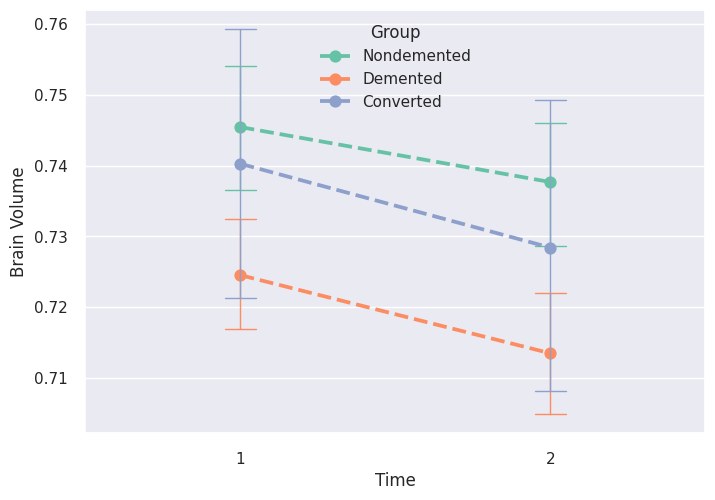

In [ ]:

sns.pointplot(data=mriEntire,x='Time',y='Brain Volume',hue='Group',capsize=.1,palette='Set2',linestyles='dashed',err_kws={'linewidth': 1})

In [ ]:
# This code asks a statistical question about brain volume changes.
# It investigates whether brain volume changes over time
# (within-subjects effect) and if these changes differ between the three
# diagnostic groups (dementia, no dementia, converted; between-subjects effect).
mriEntire2 = mriEntire.loc[:,['Subject ID',	'Time','Group','Brain Volume']]
aov= pg.mixed_anova(dv='Brain Volume',within='Time',between='Group',subject='Subject ID',data=mriEntire2)
round(aov,2)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Group,0.03,2,141,0.02,6.71,0.00,0.09,NaN
1,Time,0.01,1,141,0.01,94.25,0.00,0.40,1.0
2,Interaction,0.00,2,141,0.00,1.53,0.22,0.02,NaN


In [ ]:
# Calculate post hoc tests on significant results, with no interaction term
posthocs = pg.pairwise_tests(dv='Brain Volume', within='Time', between='Group',
                             subject='Subject ID', interaction = 'False',data=mriEntire2)
# Filter significant results
significant_results = posthocs[posthocs['p-unc'] < 0.05]
round(significant_results,3)

,Contrast,Time,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Time,-,1,2,True,True,9.672,143.000,two-sided,0.000,2.258e+14,0.255
3,Group,-,Demented,Nondemented,False,True,-3.690,129.436,two-sided,0.000,75.094,-0.633
6,Time * Group,1,Demented,Nondemented,False,True,-3.413,129.011,two-sided,0.001,32.393,-0.584
9,Time * Group,2,Demented,Nondemented,False,True,-3.856,129.952,two-sided,0.000,127.576,-0.663


## 2.2 SECOND MODEL: ANALYZING ACROSS SEX

In [ ]:
mriEntire3 = mriEntire.loc[:,['Subject ID',	'Group','Time','Brain Volume','M/F']]

mriSubset1 = mriEntire3[(mriEntire['Group'] == 'Demented')]
mriSubset2 = mriEntire3[(mriEntire['Group'] == 'Nondemented')]
mriSubset3 = mriEntire3[(mriEntire['Group'] == 'Converted')]


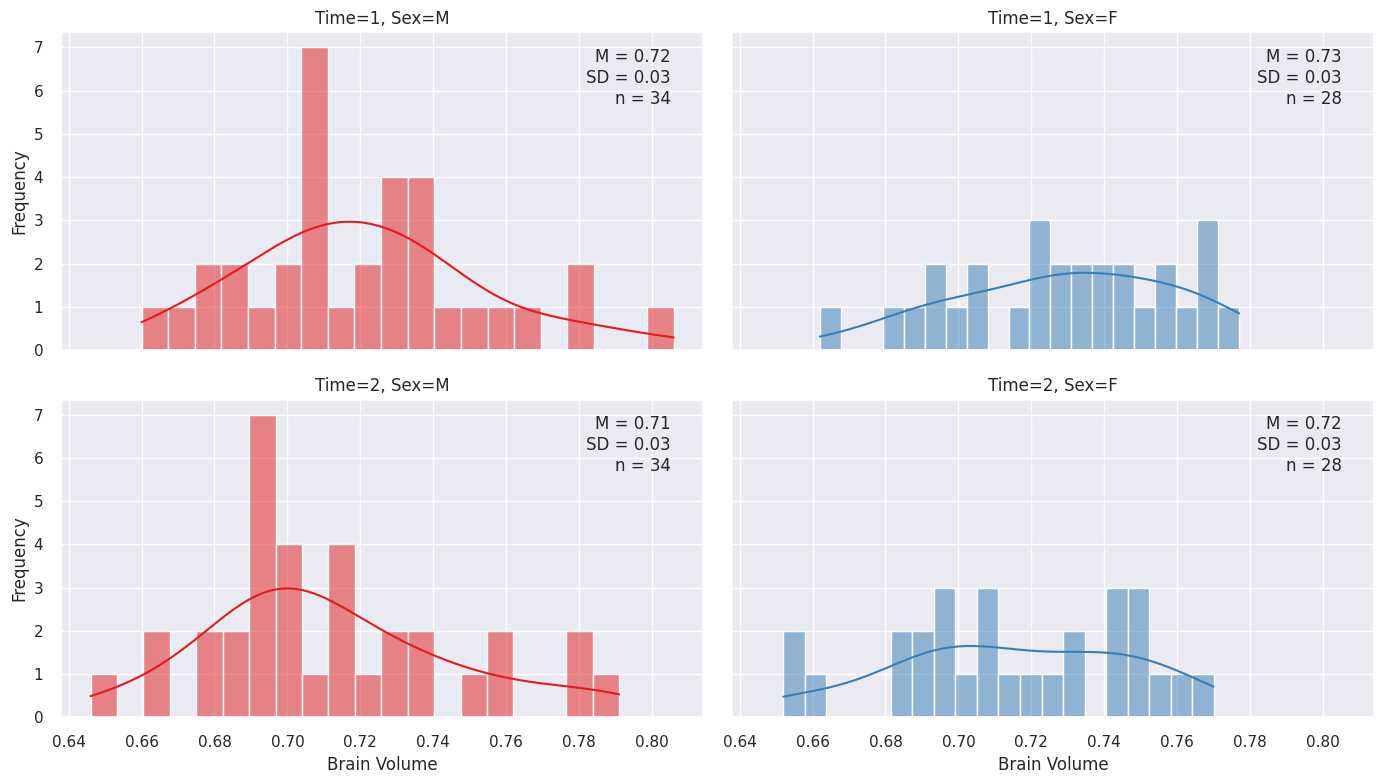

In [ ]:
sns.set()

# Get unique values of 'M/F' and 'Time', Set Colours
sexes = mriSubset1['M/F'].unique()
unique_times = mriSubset1['Time'].unique()

# Create subplots for each combination of Sex and 'Time'
fig, axes = plt.subplots(len(unique_times), len(sexes), figsize=(14, 8), sharex=True, sharey=True)

# Iterate over each Time group
for i, time_group in enumerate(unique_times):
    # Iterate over each diagnostic group
    for j, sex in enumerate(sexes):
        # Filter data for the current time and diagnostic group
        current_data = mriSubset1[(mriSubset1['Time'] == time_group) & (mriSubset1['M/F'] == sex)]['Brain Volume']

        # Plot histogram for the current time and diagnostic group
        sns.histplot(data=current_data, bins=20, kde=True, ax=axes[i, j], color=sns.color_palette("Set1")[j])

        # Calculate and display mean and standard deviation
        mean = current_data.mean()
        std_dev = current_data.std()
        n = current_data.size
        axes[i, j].text(0.95, 0.95, f'M = {mean:.2f}\nSD = {std_dev:.2f}\nn = {n}', horizontalalignment='right', verticalalignment='top', transform=axes[i, j].transAxes)

        # Set title for the subplot
        axes[i, j].set_title(f'Time={time_group}, Sex={sex}')

        # Set labels for x and y axes
        axes[i, j].set_xlabel('Brain Volume')
        axes[i, j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
print("1: With Dementia")

aov= pg.mixed_anova(dv='Brain Volume',within='Time',between='M/F',subject='Subject ID',data=mriSubset1)
round(aov,3)

1: With Dementia


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,M/F,0.001,1,60,0.001,0.431,0.514,0.007,NaN
1,Time,0.004,1,60,0.004,41.898,0.000,0.411,1.0
2,Interaction,0.000,1,60,0.000,1.985,0.164,0.032,NaN


In [ ]:
# Calculate post hoc tests on significant results, with an interaction term
posthocs1 = pg.pairwise_tests(dv='Brain Volume', within='Time', between='M/F',
                             subject='Subject ID', interaction = 'True',data=mriSubset1)

round(posthocs1,3)

,Contrast,Time,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Time,-,1,2,True,True,6.421,61.000,two-sided,0.000,5.606e+05,0.338
1,M/F,-,F,M,False,True,0.662,59.369,two-sided,0.510,0.313,0.165
2,Time * M/F,1,F,M,False,True,0.973,59.128,two-sided,0.334,0.387,0.243
3,Time * M/F,2,F,M,False,True,0.343,58.929,two-sided,0.733,0.273,0.086


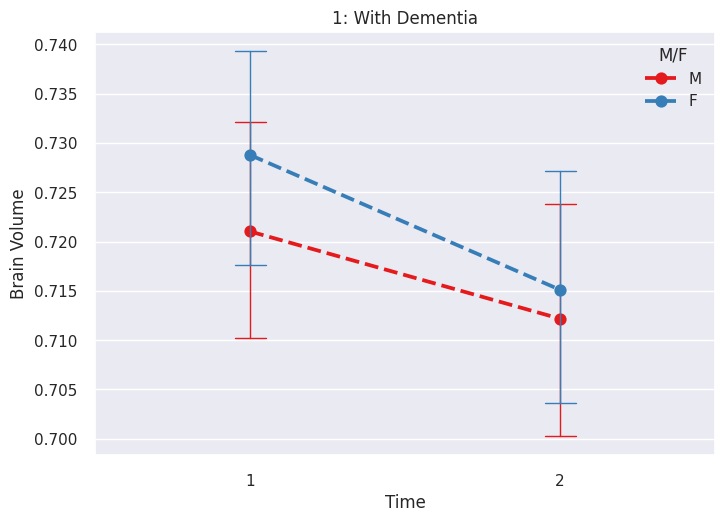

In [ ]:
sns.pointplot(data=mriSubset1, x='Time', y='Brain Volume', hue='M/F', capsize=.1, palette='Set1', linestyles='dashed', err_kws={'linewidth': 1})
plt.title("1: With Dementia")
plt.show()

In [ ]:

print("2: Nondemented")
aov= pg.mixed_anova(dv='Brain Volume',within='Time',between='M/F',subject='Subject ID',data=mriSubset2)
pg.print_table(aov.round(3))
# Calculate post hoc tests on significant results, with no interaction term
posthocs2 = pg.pairwise_tests(dv='Brain Volume', within='Time', between='M/F',
                             subject='Subject ID', interaction = 'False',data=mriSubset2)
pg.print_table(posthocs2.round(3))

2: Nondemented

ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
M/F          0.006      1     68  0.006   2.249    0.138  0.032  nan
Time         0.002      1     68  0.002  40.911    0.000  0.376    1.000
Interaction  0.000      1     68  0.000   0.016    0.900  0.000  nan


POST HOC TESTS

Contrast    Time    A    B    Paired    Parametric        T     dof  alternative      p-unc        BF10    hedges
----------  ------  ---  ---  --------  ------------  -----  ------  -------------  -------  ----------  --------
Time        -       1    2    True      True          6.442  69.000  two-sided        0.000  901800.000     0.199
M/F         -       F    M    False     True          1.403  32.940  two-sided        0.170       0.601     0.387
Time * M/F  1       F    M    False     True          1.412  33.408  two-sided        0.167       0.607     0.386
Time * M/F  2       F   

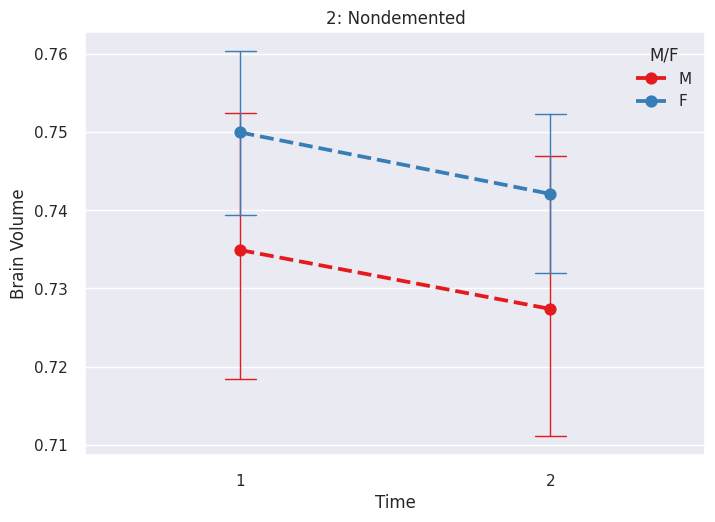

In [ ]:
sns.pointplot(data=mriSubset2, x='Time', y='Brain Volume', hue='M/F', capsize=.1, palette='Set1', linestyles='dashed', err_kws={'linewidth': 1})
plt.title("2: Nondemented")
plt.show()

In [ ]:
print("3: Converted")
# This code asks....
aov= pg.mixed_anova(dv='Brain Volume',within='Time',between='M/F',subject='Subject ID',data=mriSubset3)
pg.print_table(aov.round(3))
# Calculate post hoc tests on significant results, with no interaction term
posthocs3 = pg.pairwise_tests(dv='Brain Volume', within='Time', between='M/F',
                             subject='Subject ID', interaction = 'True',data=mriSubset3)
pg.print_table(posthocs3.round(3))

3: Converted

ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
M/F          0.010      1     10  0.010   5.396    0.043  0.350  nan
Time         0.001      1     10  0.001  12.890    0.005  0.563    1.000
Interaction  0.000      1     10  0.000   0.000    0.986  0.000  nan


POST HOC TESTS

Contrast    Time    A    B    Paired    Parametric        T     dof  alternative      p-unc    BF10    hedges
----------  ------  ---  ---  --------  ------------  -----  ------  -------------  -------  ------  --------
Time        -       1    2    True      True          3.765  11.000  two-sided        0.003  15.397     0.321
M/F         -       F    M    False     True          2.905   9.970  two-sided        0.016   3.768     1.313
Time * M/F  1       F    M    False     True          2.997   9.980  two-sided        0.013   4.185     1.323
Time * M/F  2       F    M    False     True  

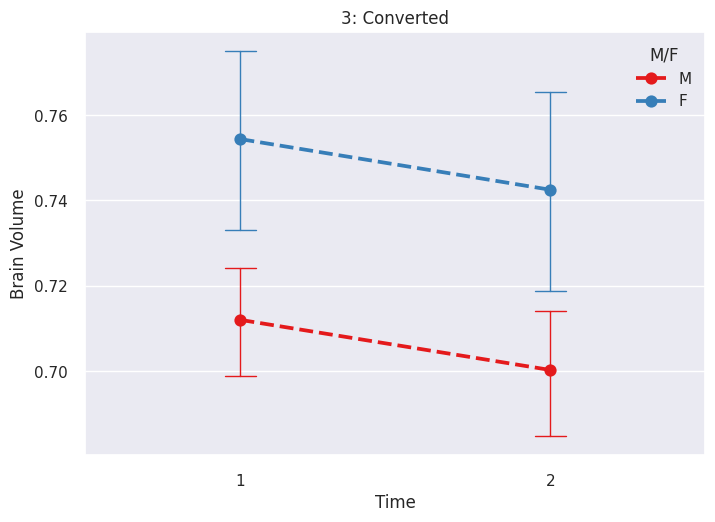

In [ ]:
sns.pointplot(data=mriSubset3, x='Time', y='Brain Volume', hue='M/F', capsize=.1, palette='Set1', linestyles='dashed', err_kws={'linewidth': 1})
plt.title("3: Converted")
plt.show()

# Power Curves

Create a statistical power analysis plot for t-tests and tell us the appropriate sample size for a theoretical experiment with power = 0.91, alpha = 0.05, and effect size = 0.7.

In [ ]:
import statsmodels.stats.power as smp
effect_size=0.7
power=0.91
alpha=0.05
power_analysis = smp.TTestIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
sample_size

print(f'Sample size needed in each group to achieve {power} power with a {effect_size} effect size: {sample_size + .5 :.0f}') # Add .5 to round up when formatting decimal

Sample size needed in each group to achieve 0.91 power with a 0.7 effect size: 46


<ipython-input-114-4b48d081357a>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 800x550 with 0 Axes>

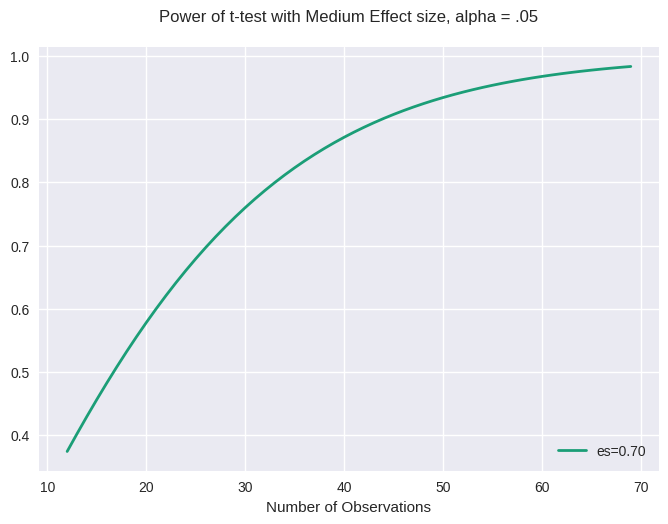

<ipython-input-114-4b48d081357a>:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 800x550 with 0 Axes>

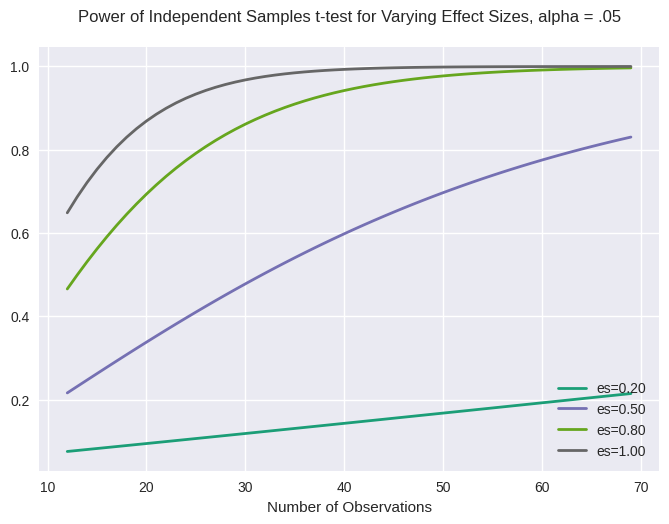

In [ ]:
from statsmodels.stats.power import TTestIndPower

# Define effect sizes and sample sizes
effect_sizes = np.array([0.7])
sample_sizes = np.arange(12, 70)

# Create an instance of TTestIndPower
power_analysis = TTestIndPower()

# Plot power curves
plt.style.use('seaborn')
fig = plt.figure()
fig = power_analysis.plot_power(
    dep_var='nobs', nobs=sample_sizes,
    effect_size=effect_sizes, alpha=0.05,
    title='Power of t-test with Medium Effect size, alpha = .05\n')

plt.show()

# plot power curves
# power analysis varying parameters
effect_sizes = np.array([0.2, 0.5, 0.8,1.0])
plt.style.use('seaborn')
fig = plt.figure()
fig = power_analysis.plot_power(
    dep_var='nobs', nobs=sample_sizes,
    effect_size=effect_sizes, alpha=0.05,
    title='Power of Independent Samples t-test for Varying Effect Sizes, alpha = .05\n')
